In [1]:
import os

import neo4j
from chromadb import HttpClient
from dotenv import load_dotenv
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START
from neo4j_graphrag.retrievers import VectorRetriever
from openai import OpenAI

from manoa_agent.embeddings import convert
from manoa_agent.prompts.promp_injection import load
from manoa_agent.retrievers.graphdb import GraphVectorRetriever

load_dotenv(override=True)

neo4j_driver = neo4j.GraphDatabase.driver(
    os.getenv('NEO4J_URI'),
    auth=(os.getenv('NEO4J_USERNAME'), os.getenv('NEO4J_PASSWORD'))
)

embedder = convert.from_open_ai(OpenAI(), "text-embedding-3-large")
http_client = HttpClient(os.getenv("CHROMA_HOST"), os.getenv("CHROMA_PORT"))

its_faq_collection = Chroma(
    collection_name="its_faq",
    client=http_client,
    embedding_function=embedder,
    collection_metadata={"hnsw:space": "cosine"}
)

policies_collection = Chroma(
    collection_name="uh_policies",
    client=http_client,
    embedding_function=embedder,
    collection_metadata={"hnsw:space": "cosine"}
)

predefined_collection = Chroma(
    collection_name="predefined",
    client=http_client,
    embedding_function=embedder,
    collection_metadata={"hnsw:space": "cosine"}
)

faq_retriever = its_faq_collection.as_retriever(
    search_type="similarity", search_kwargs={"k": 2}
    # search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.5}
)

policies_retriever = policies_collection.as_retriever(
    search_type="similarity", search_kwargs={"k": 2}
    # search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.5}
)

policies_retriever = policies_collection.as_retriever(
    search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.5}
)

predefined_retriever = predefined_collection.as_retriever(
    search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.95}
)

vector_retriever = VectorRetriever(
    neo4j_driver,
    index_name="text_embeddings",
    embedder=embedder,
    return_properties=["text"]
)

graph_retriever = GraphVectorRetriever(retriever=vector_retriever)

retrievers = {
    "its_faq": faq_retriever,
    "uh_policies": policies_retriever,
    "graphdb": graph_retriever
}

# llm = ChatOllama(model=os.getenv("OLLAMA_MODEL"), base_url=os.getenv("OLLAMA_HOST"))
llm = ChatOpenAI(model="gpt-4o")

prompt_injection_classifier = load(embedder=embedder, load_path="../data/prompt_injection_model/injection_model.joblib")

/home/exouser/miniconda3/envs/ai-agent-askus/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

from manoa_agent.agent.nodes import *

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def predefined_condition(state: PredefinedState):
    logger.info("Evaluating predefined_condition")
    if state["is_predefined"]:
        logger.info("predefined_condition: state is predefined")
        return "predefined"
    else:
        logger.info("predefined_condition: state is not predefined, branching to prompt_injection")
        return "prompt_injection"


def prompt_injection_condition(state: PromptInjectionState):
    logger.info("Evaluating prompt_injection_condition")
    if state["is_prompt_injection"]:
        logger.info("prompt_injection_condition: state is prompt injection")
        return "prompt_injection"
    else:
        logger.info("prompt_injection_condition: state is safe")
        return "safe"


def rag_agent_condition(state: GeneralAgentState):
    if state["should_call_rag"]:
        return "rag_agent"
    else:
        return "answered"


workflow = StateGraph(AgentState, output=AgentOutputState)

workflow.add_node("predefined", PredefinedNode(retriever=faq_retriever))
workflow.add_node("prompt_injection", PromptInjectionNode(prompt_injection_classifier))
workflow.add_node("reformulate", ReformulateNode(llm=llm))
workflow.add_node("get_documents", DocumentsNode(retrievers=retrievers))
workflow.add_node("rag_agent", AgentNode(llm=llm))
workflow.add_node("general_agent", GeneralAgentNode(llm=llm))

workflow.add_edge(START, "predefined")
workflow.add_edge("reformulate", "get_documents")
workflow.add_edge("get_documents", "rag_agent")
workflow.add_edge("rag_agent", END)

workflow.add_conditional_edges("prompt_injection", prompt_injection_condition,
                               {"prompt_injection": END, "safe": "general_agent"})
workflow.add_conditional_edges("predefined", predefined_condition,
                               {"predefined": END, "prompt_injection": "prompt_injection"})
workflow.add_conditional_edges("general_agent", rag_agent_condition, {"rag_agent": "reformulate", "answered": END})

agent = workflow.compile()
logger.info("Workflow compiled successfully")


INFO:__main__:Workflow compiled successfully


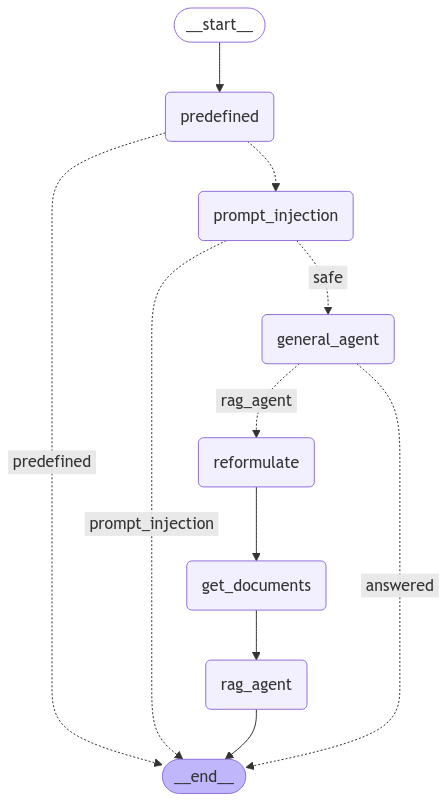

In [19]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

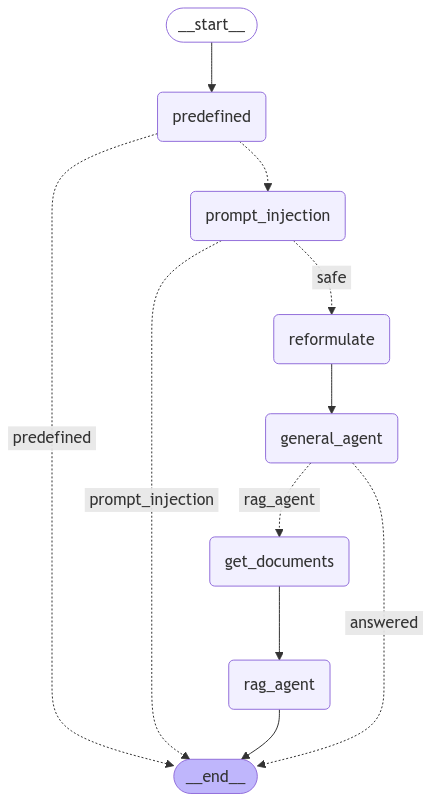

In [13]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage

input_state = AgentState(messages=[
    HumanMessage("what is the its contact info?"),
    AIMessage(
        "The ITS contact information is as follows:\n\nPhone: (808) 956-8883  \nToll Free (neighbor isles): (800) 558-2669  \nEmail: help@hawaii.edu\n\nLive Chat Support is available Monday - Friday, 8:00am - 3:00pm (excluding Holidays). You can chat at www.hawaii.edu/help/chat/.\n\nWalk-In Support is available at the Information Technology Center on the Mānoa Campus, Monday - Friday, 8:00am - 4:30pm, not available on Holidays."),
], retriever="its_faq")
agent.invoke(input_state)

INFO:manoa_agent.agent.nodes:Entering PredefinedNode.__call__
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:manoa_agent.agent.nodes:Message: 'what is the its contact info?' is not predefined
INFO:__main__:Evaluating predefined_condition
INFO:__main__:predefined_condition: state is not predefined, branching to prompt_injection
INFO:manoa_agent.agent.nodes:Entering PromptInjectionNode.__call__
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:manoa_agent.agent.nodes:Message: 'what is the its contact info?' is not a prompt injection
INFO:__main__:Evaluating prompt_injection_condition
INFO:__main__:prompt_injection_condition: state is safe
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:manoa_agent.agent.nodes:System prompt chain returned: answer=None
INFO:manoa_agent.agent.nodes:Entering ReformulateNode.__call__
INFO:manoa_agent.agent.nodes:Reformuate Node Ca

{'message': AIMessage(content='The ITS contact information is as follows:\n\nPhone: (808) 956-8883  \nToll Free (neighbor isles): (800) 558-2669  \nEmail: help@hawaii.edu\n\nLive Chat Support is available Monday - Friday, 8:00am - 3:00pm (excluding Holidays). You can chat at www.hawaii.edu/help/chat/.\n\nWalk-In Support is available at the Information Technology Center on the Mānoa Campus, Monday - Friday, 8:00am - 4:30pm, not available on Holidays.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 119, 'prompt_tokens': 687, 'total_tokens': 806, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ff092ab25e', 'finish_reason': 'stop', 'logprobs': None}, id='run-ae4f680f-f1bd-42a6-b6d5-c37e62683c18-0', usage_metadata={'input_tokens'

In [ ]:
from fastapi import FastAPI
from langserve import add_routes
import asyncio

app = FastAPI(
    title="AI Agent AskUs",
    version="1.1",
    description="A simple api server using Langchain's Runnable interfaces",
)

add_routes(
    app,
    agent,
    path="/askus",
)

import uvicorn

if __name__ == "__main__":
    config = uvicorn.Config(app, port=8002)
    server = uvicorn.Server(config)
    loop = asyncio.get_running_loop()
    loop.create_task(server.serve())

    # uvicorn.run(app, host="localhost", port=8000)

INFO:     Started server process [3180991]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8002 (Press CTRL+C to quit)



     __          ___      .__   __.   _______      _______. _______ .______     ____    ____  _______
    |  |        /   \     |  \ |  |  /  _____|    /       ||   ____||   _  \    \   \  /   / |   ____|
    |  |       /  ^  \    |   \|  | |  |  __     |   (----`|  |__   |  |_)  |    \   \/   /  |  |__
    |  |      /  /_\  \   |  . `  | |  | |_ |     \   \    |   __|  |      /      \      /   |   __|
    |  `----./  _____  \  |  |\   | |  |__| | .----)   |   |  |____ |  |\  \----.  \    /    |  |____
    |_______/__/     \__\ |__| \__|  \______| |_______/    |_______|| _| `._____|   \__/     |_______|
    
LANGSERVE: Playground for chain "/askus/" is live at:
LANGSERVE:  │
LANGSERVE:  └──> /askus/playground/
LANGSERVE:
LANGSERVE: See all available routes at /docs/
INFO:     127.0.0.1:53444 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:53444 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:53450 - "GET /playground/askus HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:53450 -